# Imports

In [16]:
pip install NumPy>=1.16.5


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Call the dataset

In [18]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')

train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)

In [19]:
train_df.head()

,0,1,2,3
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


### Handel labels DataFrames

In [20]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})

In [21]:
train_df.head()

,0,image_name,diagnosis,3
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [22]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)

In [23]:
train_df.tail()

,image_name,diagnosis
29981,55204bb8-89fc-449d-8563-e91654abea9d.png,negative
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative
29985,c56b4527-615d-414f-a375-081e6f3bbfdc.png,negative


In [24]:
train_df.diagnosis.value_counts()

positive    15994
negative    13992
Name: diagnosis, dtype: int64

In [25]:
test_df.diagnosis.value_counts()

positive    200
negative    200
Name: diagnosis, dtype: int64

In [26]:
clas = np.unique(test_df.diagnosis)
clas

array(['negative', 'positive'], dtype=object)

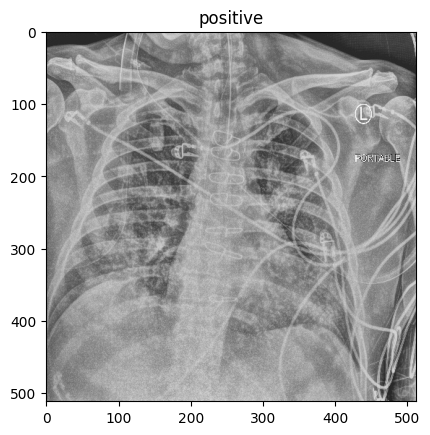

(512, 512, 3)

In [27]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape

## Image Data Generators

In [28]:
batch_size = 32
train_vla_sesd = 40
target_size = (256,256)

train_val_Gen = ImageDataGenerator( rescale = 1.0/255,
                                    validation_split=0.1)
test_Gen = ImageDataGenerator( rescale = 1.0/255)


train_data = train_val_Gen.flow_from_dataframe(train_df,
                                               train_data_path,
                                               x_col='image_name',
                                               y_col='diagnosis',
                                               target_size=target_size,
                                               class_mode='binary',
                                               batch_size=batch_size,
                                               seed=train_vla_sesd,
                                              subset='training'
                                              )
val_data = train_val_Gen.flow_from_dataframe(train_df,
                                               train_data_path,
                                               x_col='image_name',
                                               y_col='diagnosis',
                                               target_size=target_size,
                                               class_mode='binary',
                                               batch_size=batch_size,
                                               seed=train_vla_sesd,
                                              subset='validation'
                                              )
test_data = test_Gen.flow_from_dataframe(test_df,
                                       test_data_path,
                                       x_col='image_name',
                                       y_col='diagnosis',
                                       target_size=target_size,
                                       class_mode='binary',
                                       batch_size=batch_size
                                      )

Found 26988 validated image filenames belonging to 2 classes.
Found 2998 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


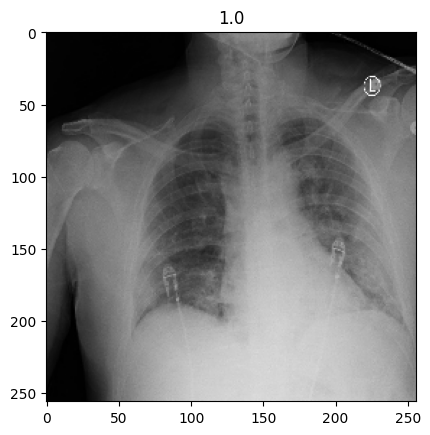

In [29]:
#the same  image with incoded labels and scaled 1/255

plt.imshow(train_data[int(rand_indx/32)][0][(rand_indx%32)-1])
plt.title(train_data[int(rand_indx/32)][1][(rand_indx%32)-1])
plt.show()

## Copy VGG-19 Model

In [30]:
ef_model = EfficientNetB3(include_top=False)

model = Sequential()

model.add(InputLayer(input_shape=(256,256,3)))
model.add(ef_model)

for layer in ef_model.layers:
    layer.trainable = False

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [31]:
lR = 1e-2
loss='binary_crossentropy'
metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

model.compile(optimizer=Adam(lr=lR), 
              loss= loss, 
              metrics=metrics)

In [ ]:
results = model.fit(train_data,
                     epochs=40,
                     validation_data=val_data,
                     steps_per_epoch=len(train_data),
                    validation_steps=len(val_data))

Epoch 1/40


2023-05-29 13:12:31.196876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


844/844 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.6869 - precision: 0.7934 - recall: 0.5264

In [ ]:
model.evaluate(test_data)

In [ ]:
yPred = model.predict(test_data)
yPred = np.where(yPred>=0.5, 1, 0)
confusion_matrix(test_data.labels, yPred)

In [ ]:

# Get the training and validation metrics
loss = results.history['loss']
val_loss = results.history['val_loss']
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
precision = results.history['precision']
val_precision = results.history['val_precision']
recall = results.history['recall']
val_recall = results.history['val_recall']

# Create subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot binary cross-entropy
axs[0, 0].plot(loss, label='training')
axs[0, 0].plot(val_loss, label='validation')
axs[0, 0].set_title('Binary Cross-Entropy')
axs[0, 0].legend()

# Plot accuracy
axs[0, 1].plot(acc, label='training')
axs[0, 1].plot(val_acc, label='validation')
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend()

# Plot precision
axs[1, 0].plot(precision, label='training')
axs[1, 0].plot(val_precision, label='validation')
axs[1, 0].set_title('Precision')
axs[1, 0].legend()

# Plot recall
axs[1, 1].plot(recall, label='training')
axs[1, 1].plot(val_recall, label='validation')
axs[1, 1].set_title('Recall')
axs[1, 1].legend()

# Show the plot
plt.show()


In [ ]:
rand_bachs = np.random.randint(0, len(test_data), 4)
rand_images = np.random.randint(0, 32, 4)

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, bach in enumerate(rand_bachs):
    for j, image in enumerate(rand_images):
        axs[i,j].imshow(test_data[bach][0][image])
        title = f'True: {test_data[bach][1][image]} Predicted: {yPred[(bach*32)+image-1]}'
        axs[i,j].set_title(title)
        
plt.show()

### saving a model in HDF5 format 

In [ ]:
model.save('Covid-19_X-rai_diagnosis.h5')